In [2]:
import numpy as np
import torch
from torch import nn
import os
import glob

In [3]:
from NeurIPS_2024.utility import predict_fuc, load_best_model
from NeurIPS_2024.linear_MLP import MLP

In [4]:
batch_size = 1
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# model, optimizer, best_val_loss, target_min, target_max = load_best_model(
#     model, optimizer,
#     '/kaggle/input/noisereduction/pytorch/default/1/best_model_NR_v2.0.pth')
model, optimizer, best_val_loss, target_min, target_max = load_best_model(
    model, optimizer, 'best_model_LR_v1.0.pth')

Best model loaded.


In [1]:
from NeurIPS_2024.linear_process import preprocess_pro
from NeurIPS_2024.utility import cal_flux, predict_spectra

predictions_spectra_test = preprocess_pro('test')


QUEUEING TASKS | :   0%|          | 0/673 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/673 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/673 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/673 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/673 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/673 [00:00<?, ?it/s]

NameError: name 'np' is not defined

In [5]:
wave_alpha_test = np.array([
    cal_flux(predictions_spectra_test[i])
    for i in range(len(predictions_spectra_test))
])
whitelight_s_test = np.array([
    predict_spectra(predictions_spectra_test[i])
    for i in range(len(predictions_spectra_test))
])  # 预测每个星球的白光缩放比例S
b = 0.007255
a = 0.000375
whitelight_s_test_normalized = (whitelight_s_test - a) / (b - a)
whitelight_s_test_reshaped = whitelight_s_test_normalized[:, np.newaxis]
data_test_reshaped = np.concatenate(
    [np.stack(wave_alpha_test),
     np.stack(whitelight_s_test_reshaped)],
    axis=1  # 按第 2 维度（axis=1）进行合并，以便后续一起处理
)
data_test_reshaped = torch.tensor(data_test_reshaped).float()

In [6]:
all_predictions = predict_fuc(model, data_test_reshaped, batch_size=1)
all_predictions = all_predictions * (target_max - target_min) + target_min
all_predictions = all_predictions.numpy()

In [7]:
from NeurIPS_2024.utility import postprocessing, competition_score
import pandas as pd

wavelengths = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/wavelengths.csv')
test_adc_info = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
    index_col='planet_id')
train_labels = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    index_col='planet_id')

In [8]:
sub_df = postprocessing(all_predictions,
                        wavelengths,
                        test_adc_info.index,
                        sigma_pred=np.tile(
                            np.where(test_adc_info[['star']] <= 1, 0.000067,
                                     0.001), (1, 283)))

In [9]:
gll_score = competition_score(train_labels.copy().reset_index(),
                              sub_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.00001)
print(f"# Estimated competition score: {gll_score:.3f}")

# Estimated competition score: 0.574


In [10]:
from sklearn.metrics import r2_score, mean_squared_error

auxiliary_folder = 'input/ariel-data-challenge-2024/'
train_solution = np.loadtxt(f'{auxiliary_folder}/train_labels.csv',
                            delimiter=',',
                            skiprows=1)

targets = train_solution[:, 1:]

In [11]:
print(f"# R2 score: {r2_score(targets, all_predictions):.3f}")
sigma_pred = mean_squared_error(targets, all_predictions, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.998
# Root mean squared error: 0.000067


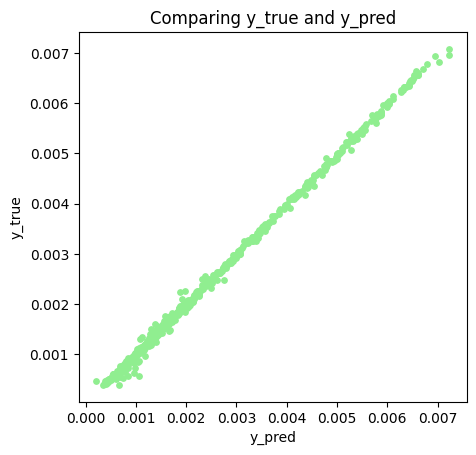

In [8]:
import matplotlib.pyplot as plt

col = 1
plt.scatter(all_predictions[:, col], targets[:, col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

In [15]:
import numpy as np
from scipy import stats

col = 3
# 假设 predict_targets 和 targets 是 numpy 数组
errors = np.abs(all_predictions[:, col] - targets[:, col])
z_scores = np.abs(stats.zscore(errors))

# 设置 Z-score 阈值，通常为 3
threshold = 3
outliers = np.where(z_scores > threshold)

# 打印异常值索引
print("Outlier lens:", len(outliers[0]))
print("Outliers:", outliers)

Outlier lens: 0
Outliers: (array([], dtype=int64),)


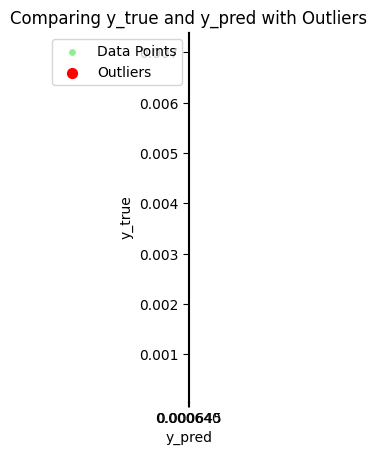

In [16]:
import matplotlib.pyplot as plt

plt.scatter(all_predictions[:, col],
            targets[:, col],
            s=15,
            c='lightgreen',
            label='Data Points')
plt.scatter(all_predictions[outliers[0], col],
            targets[outliers[0], col],
            s=50,
            c='red',
            label='Outliers')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred with Outliers')
plt.legend()
plt.show()

In [17]:
import numpy as np
from scipy import stats
from collections import Counter, defaultdict

# 假设 predict_targets 和 targets 是 numpy 数组
num_cols = all_predictions.shape[1]
threshold = 3
outlier_counts = Counter()
normal_columns = defaultdict(list)

for col in range(num_cols):
    errors = np.abs(all_predictions[:, col] - targets[:, col])
    z_scores = np.abs(stats.zscore(errors))
    outliers = np.where(z_scores > threshold)[0]
    normals = np.where(z_scores <= threshold)[0]

    # 统计每个异常点的频次
    outlier_counts.update(outliers)

    # 记录每个数据点在哪些列中是正常的
    for normal in normals:
        normal_columns[normal].append(col)

# 按频次排序
sorted_outliers = outlier_counts.most_common()

# 打印每个异常点的频次及其正常的列
for outlier, count in sorted_outliers:
    normal_cols = normal_columns[outlier]
    print(
        f"Data point {outlier} is an outlier in {count} columns and normal in columns: {normal_cols}"
    )

Data point 109 is an outlier in 11 columns and normal in columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219